# ***Import Libraries***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters


# ***1.	Data Cleaning and Preparation ***

In [ ]:
# Load the dataset
data = pd.read_csv('googleplaystore.csv')

In [ ]:
# Handle missing values
print(data.isnull().sum())
data = data.dropna()

# Remove duplicates
print(data.duplicated().sum())
data = data.drop_duplicates()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64
474


In [ ]:
# Convert fields to numerical format
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')
data['Size'] = data['Size'].replace('Varies with device', np.nan)
data['Size'] = data['Size'].astype(str).str.replace('M', 'e+6').str.replace('k', 'e+3').astype(float)
data['Installs'] = data['Installs'].astype(str).str.replace(',', '').str.replace('+', '').astype(int)
data['Price'] = data['Price'].astype(str).str.replace('$', '').astype(float)
data['Type'] = pd.factorize(data['Type'])[0]
data['Content Rating'] = pd.factorize(data['Content Rating'])[0]
data['Genres'] = pd.factorize(data['Genres'])[0]
data = data[data['Android Ver'] != 'Varies with device']
data['Android Ver'] = data['Android Ver'].astype(str)
data['Android Ver'] = data['Android Ver'].str.replace(' and up', '')

print(data.dtypes)
print(data.head())

App                       object
Category                  object
Rating                   float64
Reviews                    int64
Size                     float64
Installs                   int64
Type                       int64
Price                    float64
Content Rating             int64
Genres                     int64
Last Updated      datetime64[ns]
Current Ver                int64
Android Ver               object
Rating_diff              float64
dtype: object
                                        App        Category  Rating  Reviews  \
7                          Infinite Painter  ART_AND_DESIGN     4.1    36815   
8                      Garden Coloring Book  ART_AND_DESIGN     4.4    13791   
9             Kids Paint Free - Drawing Fun  ART_AND_DESIGN     4.7      121   
10                  Text on Photo - Fonteee  ART_AND_DESIGN     4.4    13880   
11  Name Art Photo Editor - Focus n Filters  ART_AND_DESIGN     4.4     8788   

          Size  Installs  Type  Price  Cont

# ***2.	Exploratory Data Analysis (EDA)***

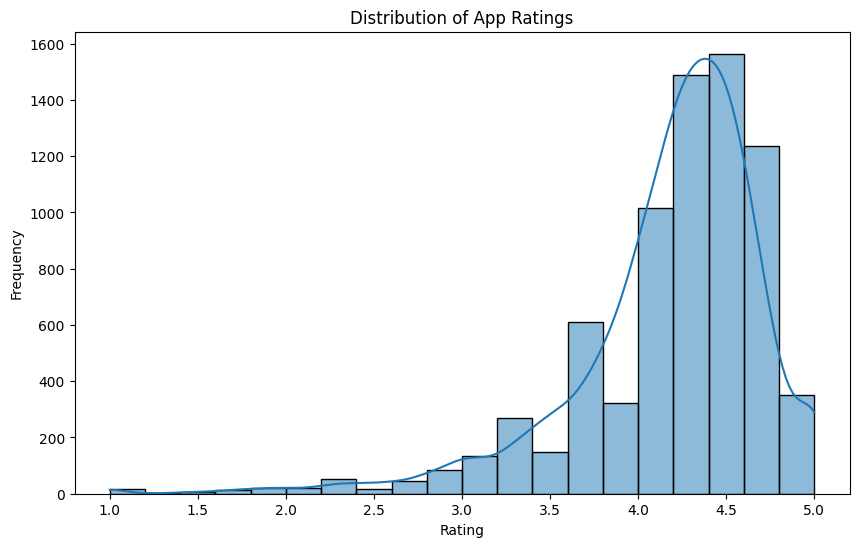

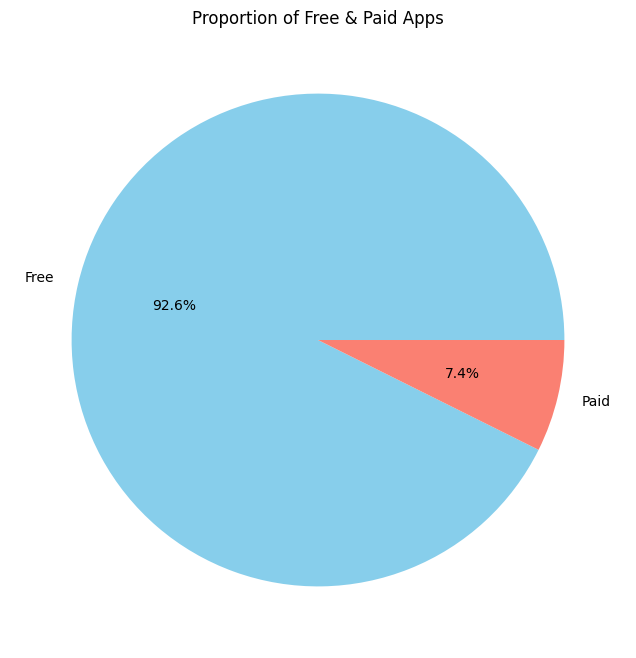

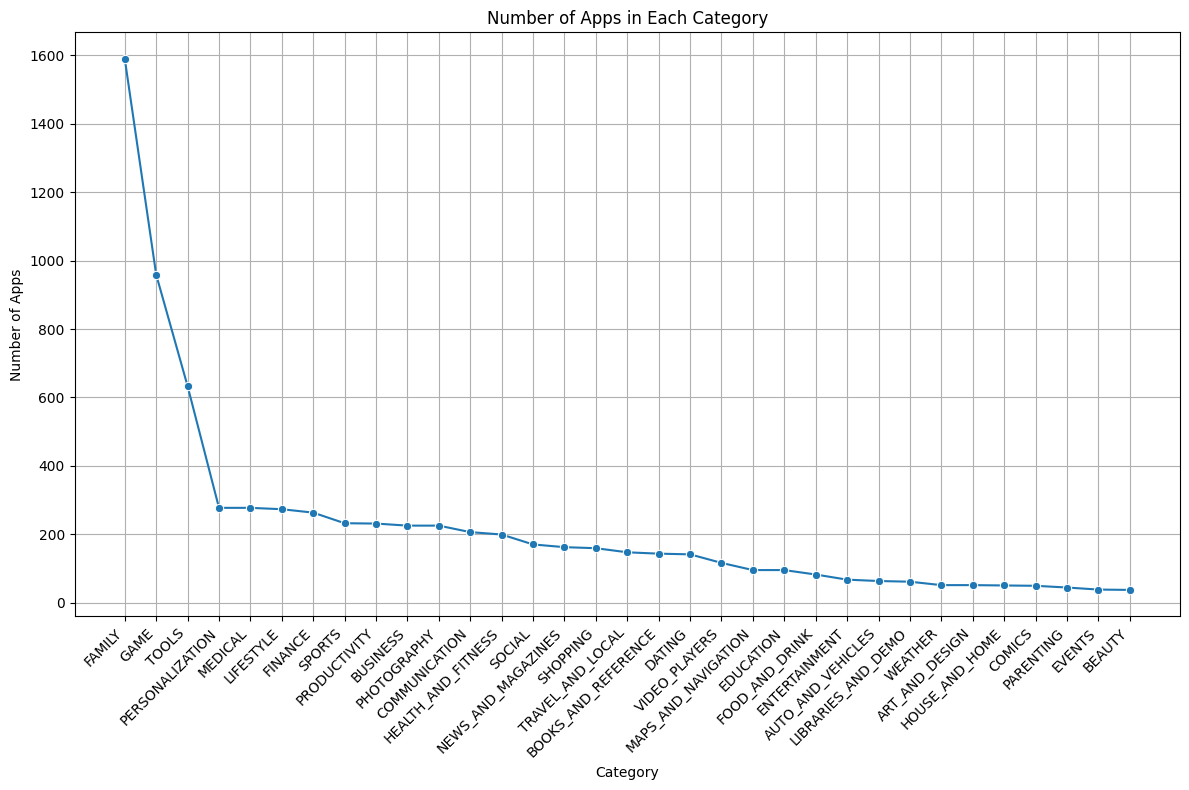

In [ ]:
# Distribution of App Ratings
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Proportion of Free vs. Paid Apps
data['Type_Label'] = data['Type'].map({0: 'Free', 1: 'Paid'})
plt.figure(figsize=(8, 8))
data['Type_Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Proportion of Free & Paid Apps')
plt.ylabel('')
plt.show()

# Categories with the Most Apps
category_counts = data['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']
plt.figure(figsize=(12, 8))
sns.lineplot(x='Category', y='Count', data=category_counts, marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Apps in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.grid(True)  # Add grid
plt.tight_layout()
plt.show()

# ***3.	Category Analysis***

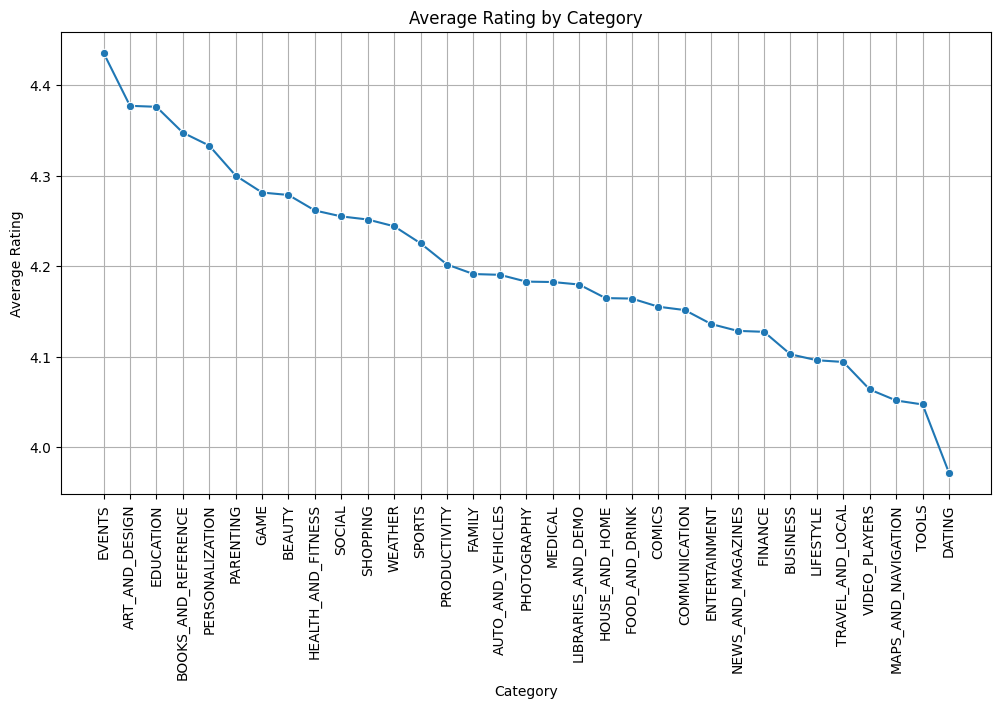

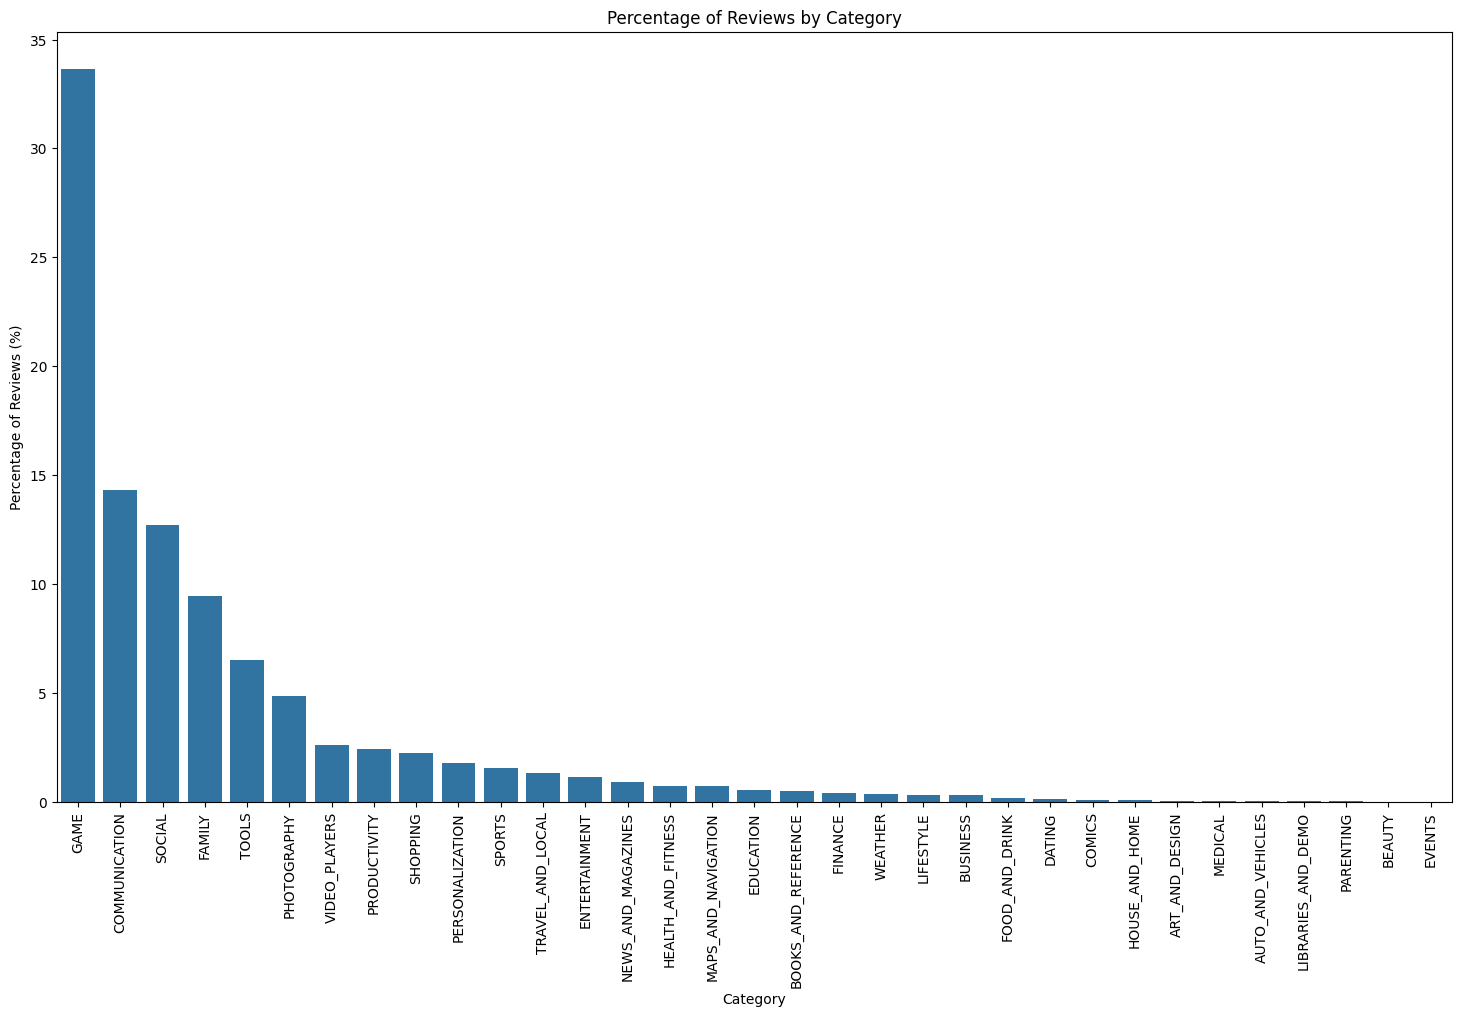

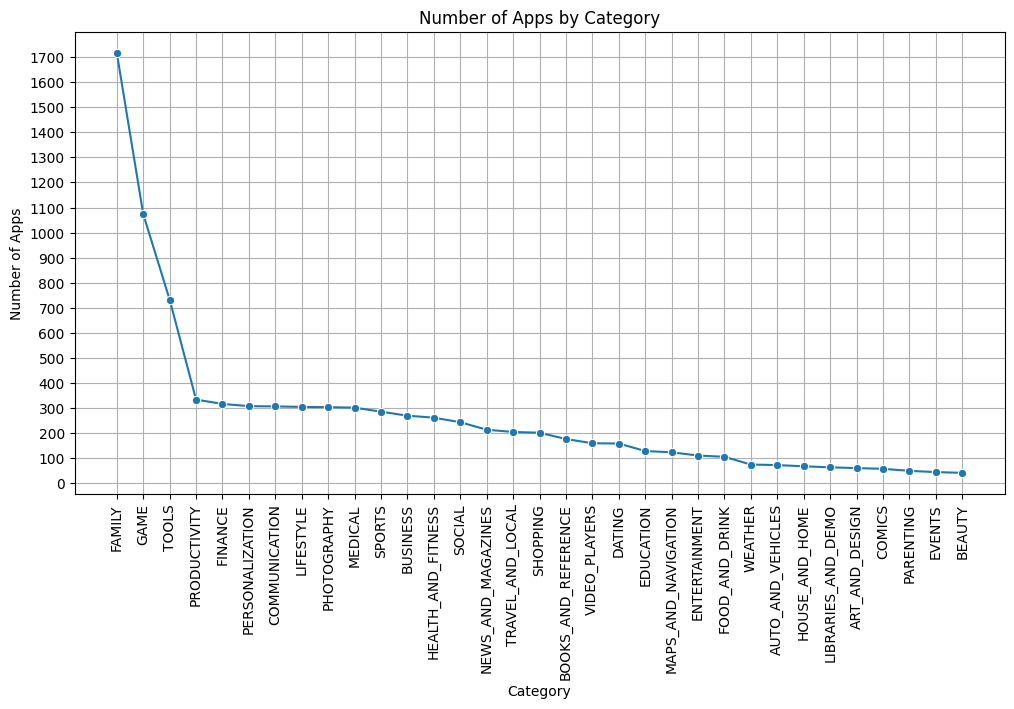

In [ ]:
# Highest Average Rating by Category
avg_rating_by_category = data.groupby('Category')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_rating_by_category.index, y=avg_rating_by_category.values, marker='o')
plt.xticks(rotation=90)
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Most Reviews by Category
total_reviews = data['Reviews'].sum()
reviews_by_category = data.groupby('Category')['Reviews'].sum().sort_values(ascending=False)
reviews_percentage = (reviews_by_category / total_reviews) * 100

plt.figure(figsize=(18, 10))
sns.barplot(x=reviews_percentage.index, y=reviews_percentage.values)
plt.xticks(rotation=90)
plt.title('Percentage of Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Percentage of Reviews (%)')
plt.show()



# Most Apps by Category
most_apps_by_category = data['Category'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.lineplot(x=most_apps_by_category.index, y=most_apps_by_category.values, marker='o')
plt.xticks(rotation=90)
plt.yticks(range(0, max(most_apps_by_category.values)+1, 100))
plt.title('Number of Apps by Category')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.grid(True)
plt.show()

# ***4.	Rating Prediction Model***

Mean Squared Error: 0.2833575316244029
ADF Statistic: -12.078735066874714
p-value: 2.2581174357703564e-22
Critical Values:
	1%: -3.431235792070717
	5%: -2.861931452140619
	10%: -2.5669783656554648


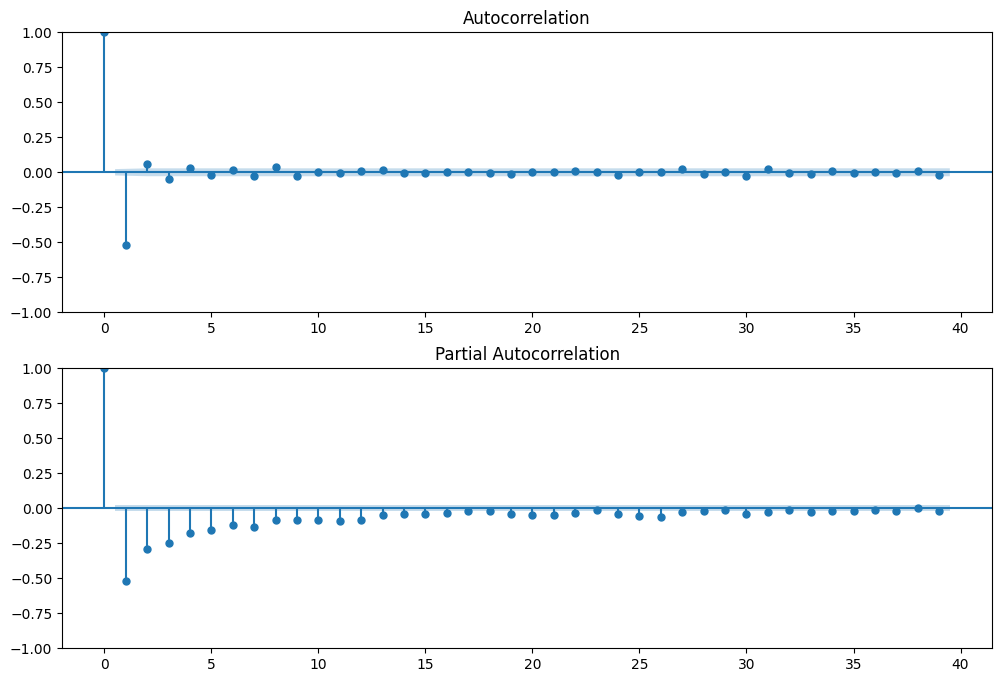

In [ ]:
# Convert 'Last Updated' column to datetime format
data['Last Updated'] = pd.to_datetime(data['Last Updated'])

# Calculatethe average rating, reviews, and installs
data_monthly = data.groupby(pd.Grouper(key='Last Updated', freq='M')).agg({
    'Rating': 'mean',
    'Reviews': 'mean',
    'Installs': 'mean'
})

# Reset index to use 'Last Updated' as a column
data_monthly.reset_index(inplace=True)

# Feature Selection
X = data[['Type', 'Price', 'Content Rating', 'Genres', 'Current Ver', 'Android Ver']]
y = data['Rating']

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Model/Fitting Model
model = LinearRegression()  # Example: Using Linear Regression
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


# Stationarity Testing
result = adfuller(data['Rating'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# If not stationary, perform differencing
data['Rating_diff'] = data['Rating'] - data['Rating'].shift(1)
data.dropna(inplace=True)

# ARIMA Model Identification
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Rating_diff'], ax=ax[0])
plot_pacf(data['Rating_diff'], ax=ax[1])
plt.show()

In [ ]:
# ARIMA Model Identification
arima_order = (2, 1, 0)

# ARIMA Model Fitting
arima_model = ARIMA(data['Rating'], order=arima_order)
arima_results = arima_model.fit()

print(arima_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Rating   No. Observations:                 7411
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6736.691
Date:                Fri, 12 Apr 2024   AIC                          13479.382
Time:                        02:44:58   BIC                          13500.114
Sample:                             0   HQIC                         13486.505
                               - 7411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6725      0.008    -80.589      0.000      -0.689      -0.656
ar.L2         -0.2920      0.008    -34.865      0.000      -0.308      -0.276
sigma2         0.3607      0.004    102.541      0.0

# ***5.	Trend Analysis***

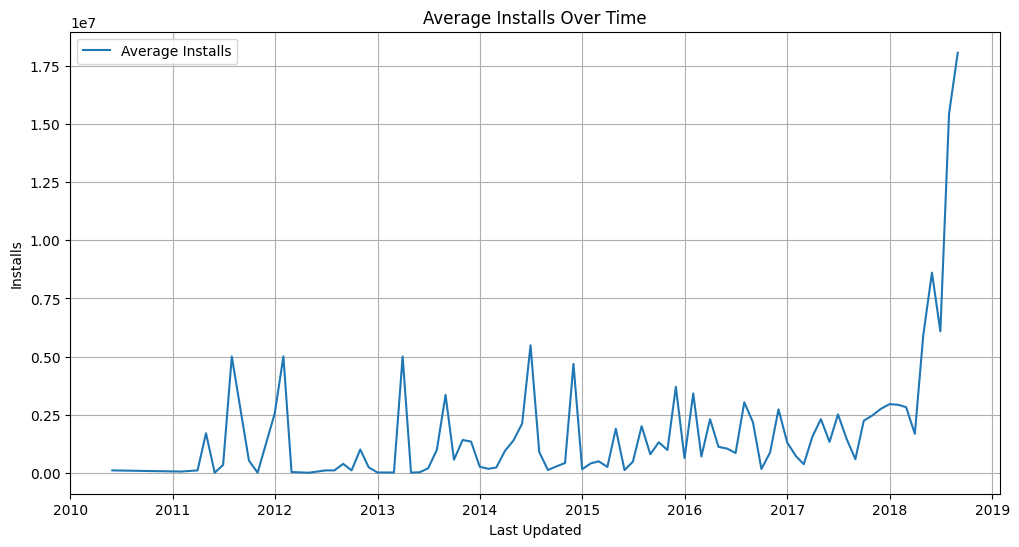

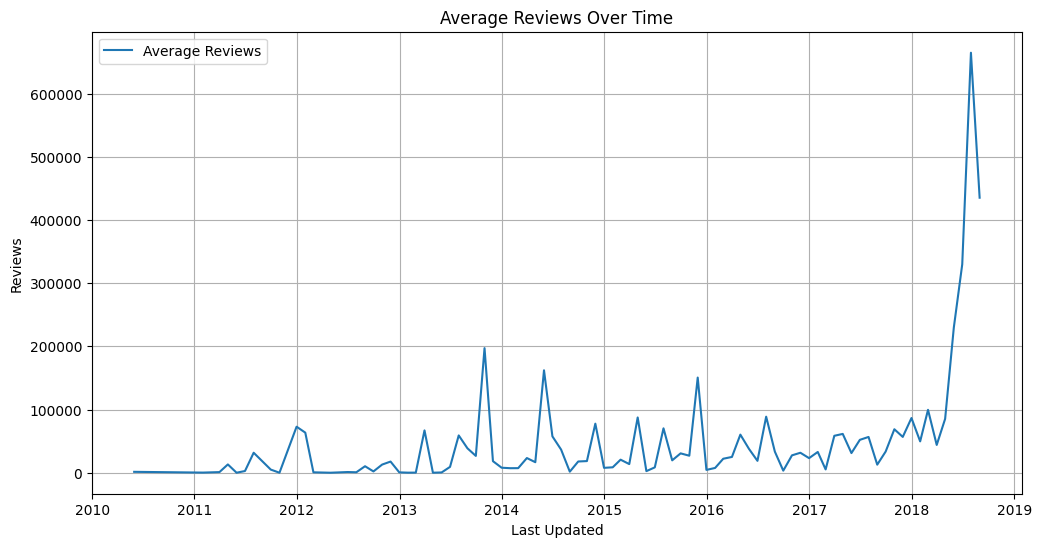

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


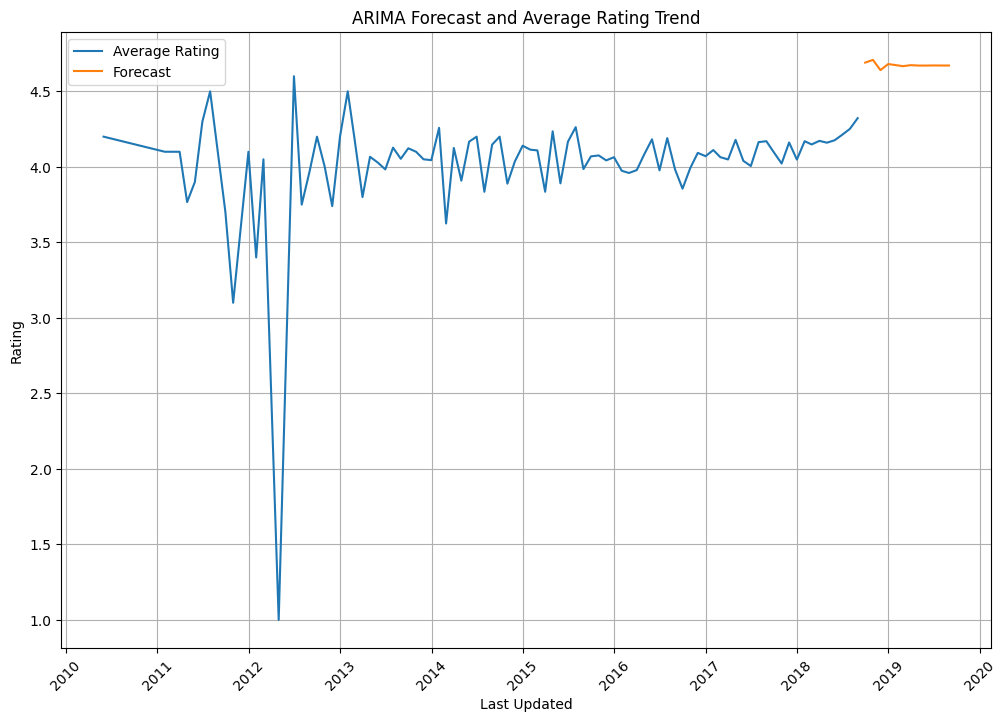

In [ ]:
register_matplotlib_converters()

# Average installs over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x='Last Updated', y='Installs', label='Average Installs')
plt.title('Average Installs Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Installs')
plt.grid(True)
plt.legend()
plt.show()

# Average reviews over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x='Last Updated', y='Reviews', label='Average Reviews')
plt.title('Average Reviews Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Reviews')
plt.grid(True)
plt.legend()
plt.show()

# Forecasting
forecast_steps = 12
forecast_index = pd.date_range(start=data_monthly['Last Updated'].max(), periods=forecast_steps + 1, freq='M')[1:]
forecast = arima_results.forecast(steps=forecast_steps)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=data_monthly, x='Last Updated', y='Rating', label='Average Rating')
plt.plot(forecast_index, forecast, label="Forecast")
plt.xlabel("Last Updated")
plt.ylabel("Rating")
plt.title("ARIMA Forecast and Average Rating Trend")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


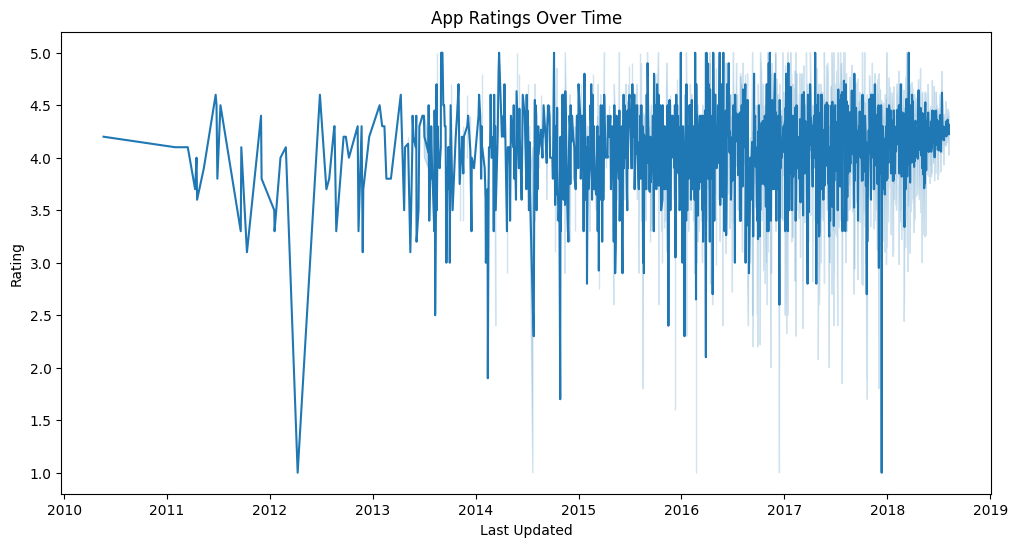

<Figure size 1200x600 with 0 Axes>

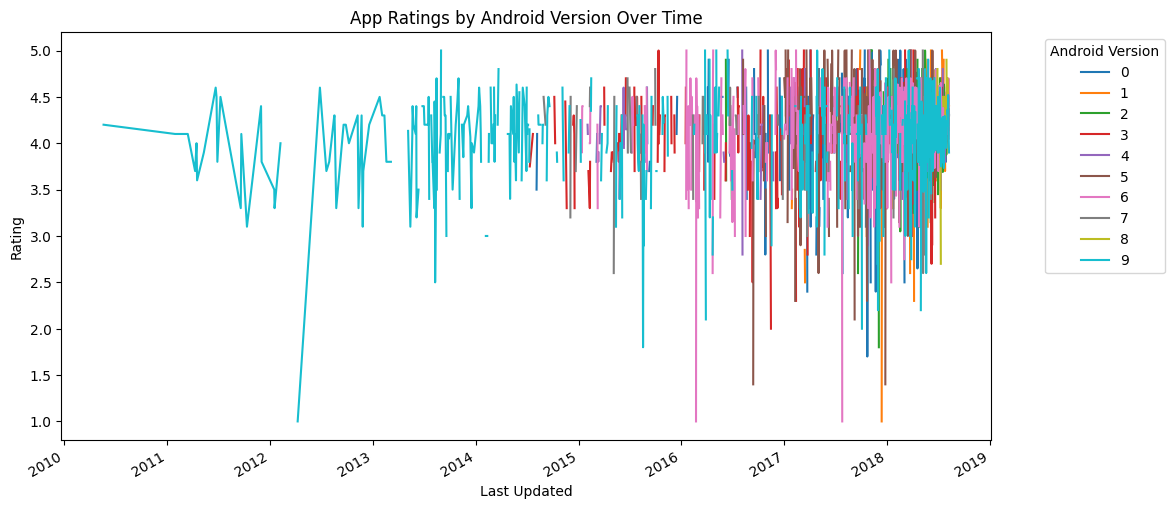

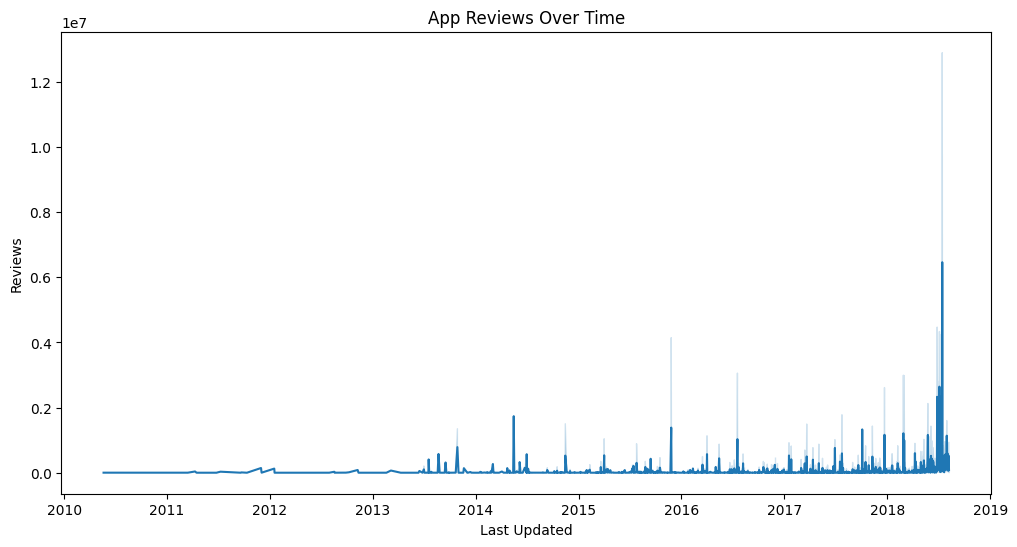

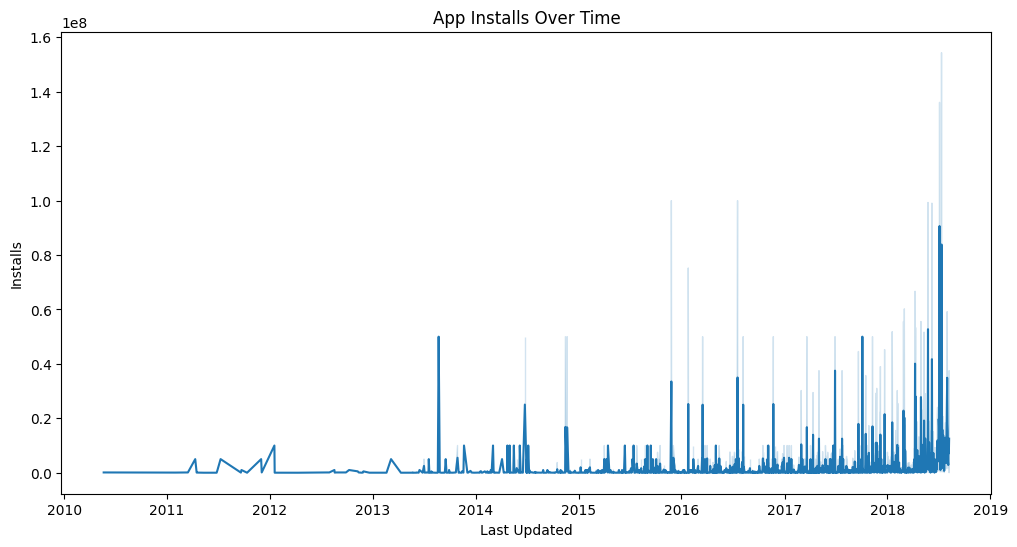

In [ ]:
# App ratings over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Last Updated', y='Rating', data=data)
plt.title('App Ratings Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Rating')
plt.show()

# App ratings by Android version
data['Android Ver'] = pd.to_numeric(data['Android Ver'], errors='coerce')
data.loc[data['Android Ver'] > 9, 'Android Ver'] = 9
plt.figure(figsize=(12, 6))
rating_by_android = data.groupby(['Last Updated', 'Android Ver'])['Rating'].mean().unstack()
rating_by_android.plot(kind='line', figsize=(12, 6))
plt.title('App Ratings by Android Version Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Rating')
plt.legend(title='Android Version', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Analysis of app reviews over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Last Updated', y='Reviews', data=data)
plt.title('App Reviews Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Reviews')
plt.show()

# App installs over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Last Updated', y='Installs', data=data)
plt.title('App Installs Over Time')
plt.xlabel('Last Updated')
plt.ylabel('Installs')
plt.show()

#***6.	Impact of Reviews on Ratings***

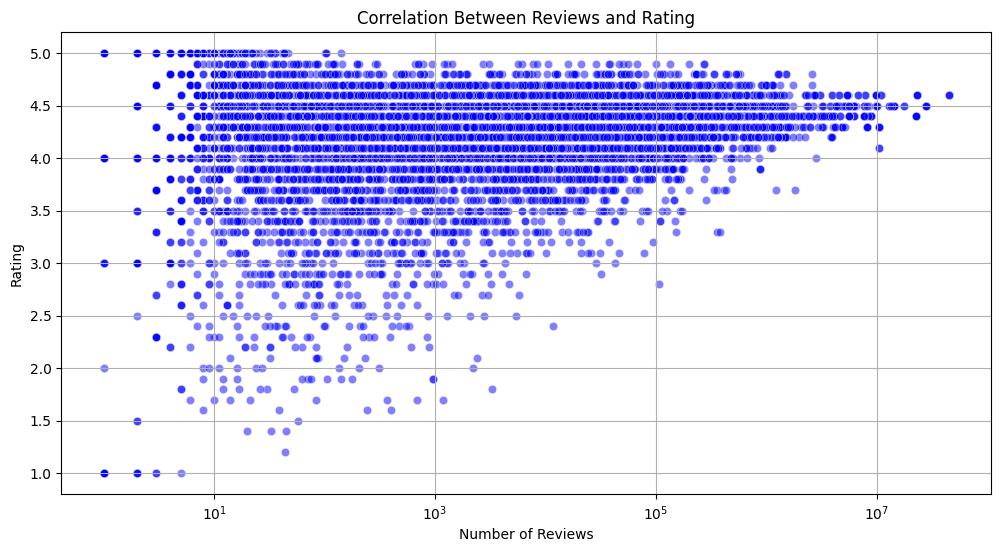

In [ ]:
# Scatter plot of Reviews & Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Reviews', y='Rating', data=data, alpha=0.5, marker='o', color='b')
plt.title('Correlation Between Reviews and Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the correlation coefficient
correlation = data['Reviews'].corr(data['Rating'])
print(f"Correlation between Reviews and Rating: {correlation}")

Correlation between Reviews and Rating: 0.08047248722005733


***Other variables' correlation to rating***

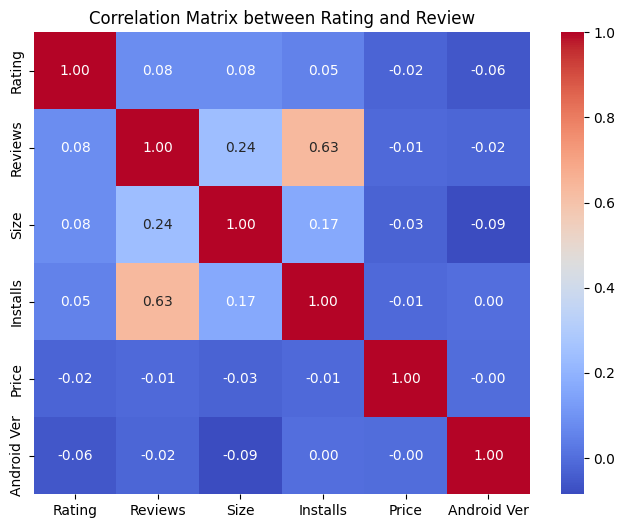

In [ ]:
data_subset = data[[ 'Rating', 'Reviews', 'Size', 'Installs', 'Price','Android Ver']]

# Calculate the correlation matrix
correlation_matrix = data_subset.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Rating and Review')
plt.show()
